In [ ]:
# La práctica deberá realizarse de manera individual y debe entregarse en la plataforma de Instituto BME.

# Para cada ejercicio: 
# 1) Entregad un fichero en ipython notebook (.ipynb) ejecutable en Colab, y
# 2) cada notebook ha de incluir un comentario sobre el ejercicio y sus resultados.

# 1) Utilizando datos de bolsa (puedes utilizar los de la práctica de CNNs) haz un regresor 
# que prediga el valor de apertura de apple del dia siguiente. 

# Una vez hecho esto, utilizando una red auxiliar, calcula la incertidumbre de predicción 
# de la primera red (usando como etiquetas a predecir el valor absoluto del error de 
# predicción de la primera red). 
# Haz lo mismo pero utilizando solo una red mediante el uso de Tensor Flow Probability.

In [ ]:
# ESTE EJERCICIO SOLO ME HA IDO EN COLAB POR EL TEMA DE CAMBIAR 
# VERSIONES DE PYTHON
# ver la version que tengo de python en Colab pq TFP solo va con version 3.9
!python --version
!sudo update-alternatives --config python3
# las alternativas que me dan es version 3.8 o 3.10. Intento cambiar a 3.8
# Selecciono 0 pq para el principio de este ejercicio prefuiero la ultima posible

!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1

!sudo apt install python3-pip
!python3 --version

Python 3.10.11
There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.10   2         auto mode
  1            /usr/bin/python3.10   2         manual mode
  2            /usr/bin/python3.8    1         manual mode

Press <enter> to keep the current choice[*], or type selection number: 0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-pip python3-setuptools python3-wheel
0 upgraded, 4 newly installed, 0 to remove and 24 not upgraded.
Need to get 2,389 kB of archives.
After this operation, 4,933 kB of additional disk space will be used.
Get:1 http://archive.ub

In [ ]:
# Refencencia para este ejercicio Prac_CNN_RNN_Ej04_Fernando_Gallego.ipynb

In [33]:
# 0 Uso como referencia las funciones que use en Prac_CNN_RNN_Ej04_Fernando_Gallego.ipynb
def sacar_close_normalizado_y_con_numero_de_valores_SIN_RETORNO_LOG (y):
    # Para leer datos lo mejor es usar la toolbox pandas
    # Los datos se han sacado de:
    # https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/version/3
    
    
    #dd_msft = pd.read_csv("msft.us.txt", delimiter=",")
    #msft_op = dd_msft['Open'].values
    #print(msft_op.shape)
    
    print(y.shape)
    
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.plot(y)

    DAT = y
    DAT.shape

    # #deberia normalizar entre 0 y 1; que se haria de forma facil
    # # # Normalizo los valores para que trabaje de 0 a 1 luego el nn.
    valor_a_normalizar = DAT.max()
    DAT = DAT/ valor_a_normalizar

    # Los coloco todos juntos en un dataset. Asi luego me sale tambien los numeros de variables que lo nesita el model  convolucional
    # DAT = np.zeros((data_googl.shape[0],3))
    DAT_1 = np.zeros((y.shape[0],1))

    DAT_1[:,0] = DAT
    # Los ploteo
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.plot(DAT_1[:,0])
    print(DAT_1.shape)
    
    # import matplotlib.pyplot as plt
    # %matplotlib inline
    # plt.figure()
    # plt.plot(DAT_1[:,0])
    #plt.plot(DAT_rent[:,1])
    #plt.plot(DAT_rent[:,2])
       
    
    return DAT_1

def Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG,DAT_1):
    # Reordeno el dataset para hacer bloques de LAG dias
    #LAG = 11
    DAT_TS = np.zeros((DAT_1.shape[0]-LAG,LAG,DAT_1.shape[1]))

    for ii in range(0,DAT_1.shape[0]-LAG):
        #print(DAT_TS.shape)
        #print(DAT_1.shape)
        DAT_TS[ii,:,:] = DAT_1[ii:ii+LAG,:]
    # Tengo (#muestras,#longitud,#variables)

    #Separaro todo el dataset en los datos de apertura de 10 días anteriores para estimar el valor del día
    #actual
    #Ntr = np.floor(DAT_TS.shape[0]/2)
    Ntr = np.floor(DAT_TS.shape[0])
    # data_x = DAT_TS[range(0,np.int(Ntr)),0:LAG-1,:]
    data_x = DAT_TS[range(0,int(Ntr)),0:LAG-1,:]

    Y_target = 0
    #data_y = DAT_TS[range(0,np.int(Ntr)),LAG-1,Y_target]
    data_y = DAT_TS[range(0,int(Ntr)),LAG-1,Y_target]


    #hago el split de train y test
    from sklearn.model_selection import train_test_split
    x_train, x_test, t_train, t_test = train_test_split(data_x, data_y, test_size=0.33, random_state=12)
    return x_train, x_test, t_train, t_test, data_x, data_y

def activo_caso_1(x_train, x_test, t_train, t_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout,MaxPooling2D, Conv1D, MaxPooling1D, GRU
    from tensorflow.keras import regularizers
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import shutil

    !pip install -q -U keras-tuner
    import keras_tuner as kt
    # si nos dejara el enunciado poner una densa al final; la densa aprende.
    # Entendi en clase que la parte de convoluciones establece caracteriticas
    # y la densa es la que va a ajustando y aprendiendo a partir d eals caracteriticas 
    # que la parte concolucional saca
    # Definimos un modelo con dos capa convolucional 1D y 1 capa densa
    model = Sequential()
    model.add(Conv1D(10, 3, input_shape=x_train.shape[1:],padding='same'))
    model.add(Conv1D(10, 3, activation='relu',padding='same'))#,input_shape=x_train.shape[1:],))
    #model.add(Flatten())
    model.add(GRU(1))
    
    
    # model = Sequential()
    # model.add(Conv1D(15,3, input_shape=(10,1),padding='same'))
    # #model.add(Conv1D(5,3, input_shape=(10,1),padding='valid'))
    # #model.add(MaxPooling1D(2))
    # #model.add(Bidirectional(GRU(5,return_sequences=True), input_shape=(10,1), merge_mode="ave")
    # model.add(GRU(5))
    # model.add(Flatten())
    # model.add(Dense(1))

    #model.summary()

    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error', metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mae', metrics=['accuracy'])
    model.summary()

    # Vamos a usar el callback de earlystopping y ReduceLROnPlateau
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    #early_stopping = EarlyStopping(monitor='val_loss', patience=12, min_delta=0.1)
    early_stopping = EarlyStopping(monitor='loss', patience=12, min_delta=0.1)

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.01)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=5, min_lr=0.1)


    # Entrenamos el modelo, nos guardamos la evolución en 'history' 
    # Esto es equivalente a usar callbacks para history
    hist = model.fit(x_train, t_train, batch_size=32, epochs=100, verbose=1, validation_split = 0.1) # antes epochs=1000
    
    #Parametros para evaluar
    score_train, score_test = graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist)
    ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model)
    
    return model, hist
  
def activo_caso_2(x_train, x_test, t_train, t_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout,MaxPooling2D 
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, GlobalAveragePooling1D,GlobalMaxPooling1D
    from tensorflow.keras import regularizers
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import shutil

    !pip install -q -U keras-tuner
    import keras_tuner as kt
    model = Sequential()
    model.add(GRU(10, input_shape=(10,1),return_sequences=True))
    model.add(Conv1D(5, 3, activation='relu',padding='same'))
    model.add(Conv1D(1, 3, activation='relu',padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1))# nuevo

    # Compilamos el modelo
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error', metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mae', metrics=['accuracy'])
    model.summary()

    # Vamos a usar el callback de earlystopping y ReduceLROnPlateau
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    #early_stopping = EarlyStopping(monitor='val_loss', patience=12, min_delta=0.1)
    early_stopping = EarlyStopping(monitor='loss', patience=12, min_delta=0.1)

    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.01)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=5, min_lr=0.1)


    # Entrenamos el modelo, nos guardamos la evolución en 'history' 
    # Esto es equivalente a usar callbacks para history
    hist = model.fit(x_train, t_train, batch_size=32, epochs=100, verbose=1, validation_split = 0.1) # antes epochs=1000
    
    #Parametros para evaluar
    score_train, score_test = graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist)
    ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model)
    
    return model, hist
# no se necesita
def datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model):
    salida=np.zeros((17))
    #trainableParams
    salida[0] = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    #nonTrainableParams
    salida[1] = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    #totalParams
    salida[2] = salida[0] + salida[1]
    
    #Train
    score = model.evaluate(x_train, t_train)
    salida[3] = score[0]
    salida[4] = score[1]
    y_hat = model.predict(x_train)
    # El  error de la predicion en train
    salida[5] = np.mean(abs(y_hat[:,0]-t_train))
    # La media de error en la prediccion en train 
    salida[6] =np.mean(np.abs(t_train))
    
    #Test
    score = model.evaluate(x_test, t_test)
    salida[7] = score[0]
    salida[8] = score[1]
    y_hat_test = model.predict(x_test)
    # El  error de la predicion en test
    salida[9] = np.mean(abs(y_hat_test[:,0]-t_test))
    # La media de error en la prediccion en test
    salida[10] = np.mean(np.abs(t_test))
    
    # numero de datos de entrada en train
    salida[11] = x_train.shape[0]
    #dimensiones de la entrada
    salida[12] =len(x_train.shape)
    # valor de la dimension 1 de la entrada
    if salida[12] >= 1:
        salida[13] = x_train.shape[0]
    # valor de la dimension 2 de la entrada
    if salida[12] >= 2:
        salida[14] = x_train.shape[1]
    # valor de la dimension 3 de la entrada
    if salida[12] >= 3:
        salida[15] = x_train.shape[2]
    # valor de la dimension 4 de la entrada
    if salida[12] >= 4:
        salida[16] = x_train.shape[3]
    
    print(len(salida))
    
    import pandas as pd 
    df = pd.read_csv ('metricas.csv', index_col=0) 
    print(df.shape)
    df[model_title] = salida
    df.to_csv('metricas.csv') 

    return salida, df
# Evaluamos el modelo segun los datos mas generales para evaluarlo

def graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist):
    #Train
    score = model.evaluate(x_train, t_train)
    print('SCORE DE TRAIN:')
    print(score)

    #Test
    print('SCORE DE TEST:')
    score_1 = model.evaluate(x_test, t_test)
    print(score_1)

    n_epochs = len(hist.history['loss'])
    hd = hist.history
    epochs = range(1, n_epochs+1)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(epochs, hd['accuracy'], "r", label="train")
    plt.plot(epochs, hd['val_accuracy'], "b", label="valid")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, hd['loss'], "r", label="train")
    plt.plot(epochs, hd['val_loss'], "b", label="valid")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss")
    plt.legend()
    plt.show()
    return score, score_1

#Cree esta funcion segun lo que Valero son ensenaba en clase
def ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model):
    
    #ESTUDIO GRAFICO DE RESULTADOS PARA EVALUAR
    # Evaluamos el modelo en train
    score = model.evaluate(x_train, t_train, verbose=0)
    print(f'Evaluamos el modelo en train_score: {score}')

    # Predecimos con los datos de train
    y_hat = model.predict(x_train)
    print(f'Predecimos con los datos de train: {np.mean(abs(y_hat[:,0]-t_train))}')
    print(f'Predecimos con los datos de train_cantidad/dimensiones de datos:{y_hat.shape}')
    print(f' La media de error en la prediccion en entrenamiento es: {np.mean(np.abs(t_train))}')

    # Predecimos con los datos de test
    y_hat_test = model.predict(x_test)
    print(f' El  error de la predicion usando datos de test es de : {np.mean(abs(y_hat_test[:,0]-t_test))}')
    print(f' La media de error en la prediccion en test es: {np.mean(np.abs(t_test))}')

    import matplotlib.pyplot as plt
    %matplotlib inline
    fig, ((ax1, ax2),(ax3, ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(20, 10)) 
    # Mostramos las predicciones de entrenamiento
    print(f'Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:')

    #plt.figure()
    ax1.plot(y_hat[:,0], label='y_hat[:,0] datos')    
    ax1.plot(t_train, label='t_train predicciones')
    ax1.grid(True)
    #ax1.xlabel("valores")
    #ax1.ylabel("nuero de dato ordinalmente")
    ax1.legend()

    #plt.figure()
    ax2.plot(t_train,y_hat[:,0],'.', label='t_train VSy_hat[:,0],')
    ax2.grid(True)
    #ax2.xlabel("t_train")
    #ax2.ylabel("y_hat[:,0],")
    ax2.legend()

    # Mostramos las predicciones de test
    ax3.plot(y_hat_test[:,0], label='y_hat_test[:,0] datos')
    ax3.plot(t_test, label=' t_testpredicciones')
    ax3.grid(True)
    #ax3.xlabel("valores")
    #ax3.ylabel("nuero de dato ordinalmente")
    ax3.legend()

    ax4.plot(t_test,y_hat_test[:,0],'.', label='t_test VS y_hat_test[:,0]')
    ax4.grid(True)
    #ax4.xlabel("t_test")
    #ax4.ylabel("y_hat_test[:,0]")
    ax4.legend()

    
    ax5.plot(model.weights[0].numpy().reshape(-1),'o-',label="Pesos neurona primera capa")
    ax5.grid(True)
    #ax5.xlabel("numero de la neurona ordinalmente")
    #ax5.ylabel("peso de la neurona")
    #ax5.title("Pesos neurona primera capa")
    ax5.legend()
    
    return

In [ ]:
# 1 Importo las librerias que necesito
!pip install xlrd 
import pandas as pd 
import numpy as np

!pip install yfinance
!pip install talib

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

import pandas as pd

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 2 Descargo data commodities de yahoo ya que el ejercicio lo 
# voy a hacer con la data que usare para el TFM. 
# este ejercicio lo voy a realizar con el valor del 'NATURALGAS'/"NG=F"
yahoo_commodities= ['NATURALGAS', 'GOLD', 'WTICRUDE', 'BRENTCRUDE', 'SOYBEANS', 'CORN', 'COPPER', 'SILVER', 'LIVECATTLE', 'SOYBEANOIL', 'ALUMINIUM', 'SOYBEANMEAL', 'WHEAT', 'SUGAR', 'GASOLINE', 'COFFEE', 'LEANHOGS', 'HRWWHEAT', 'COTTON', 'RBOB_Gasoline', 'Cocoa', 'Feeder_Cattle', 'Heating_Oil', 'Lumber', 'Oat', 'Palladium', 'Platinum', 'Lead', 'OrangeJuice', 'RoughRice']
yahoo_commodities_ticker=["NG=F", "GC=F", "CL=F", "BZ=F", "ZS=F","ZC=F", "HG=F", "SI=F", "LE=F", "ZL=F","EDP=F", "ZM=F", "ZW=F", "SB=F", "CL=F", "KC=F", "HE=F", "KE=F", "CT=F", "RB=F","CC=F", "GF=F", "HO=F", "LBS=F", "ZO=F", "PL=F", "PA=F", "LFW=F", "OJ=F", "ZR=F"]
df_yahoo_commodities_close = pd.read_csv('df_yahoo_commodities_close.csv')
df_yahoo_commodities_close_returns = pd.read_csv('df_yahoo_commodities_close_returns.csv')
y = df_yahoo_commodities_close['NG=F']
#y = df_yahoo_commodities_close_returns['NG=F']
x = range(0,y.shape[0])
x = np.asarray(x)
y = np.asarray(y)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement talib (from versions: none)
ERROR: No matching distribution found for talib
(5552,)
(5552, 1)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 10, 10)            390       
                                                                 
 conv1d_18 (Conv1D)          (None, 10, 5)             155       
                                                                 
 conv1d_19 (Conv1D)          (None, 10, 1)             16        
                                                             

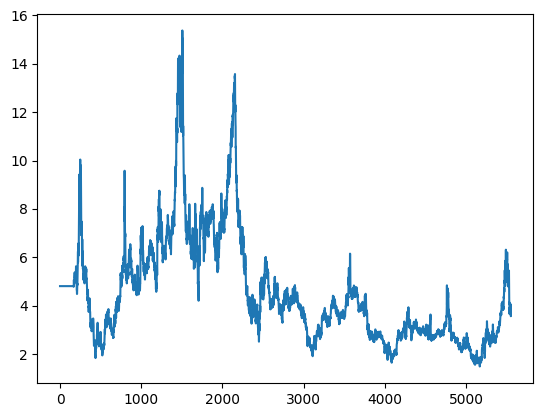

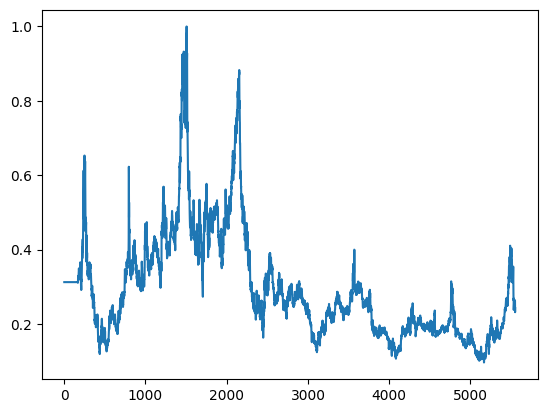

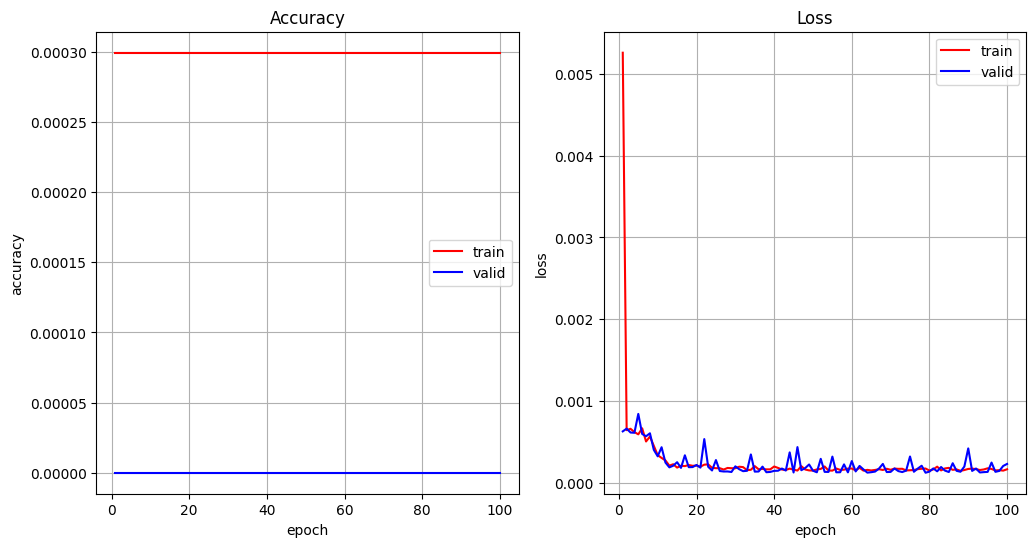

Evaluamos el modelo en train_score: [0.00022323780285660177, 0.00026939655072055757]
116/116 [==============================] - 1s 2ms/step
Predecimos con los datos de train: 0.011971595708092758
Predecimos con los datos de train_cantidad/dimensiones de datos:(3712, 1)
 La media de error en la prediccion en entrenamiento es: 0.2942794820718746
58/58 [==============================] - 1s 3ms/step
 El  error de la predicion usando datos de test es de : 0.01215836196689208
 La media de error en la prediccion en test es: 0.2934496061366643
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:
(5541, 10, 1) (5541,) (5541, 1)
0.04162821 0.04139654


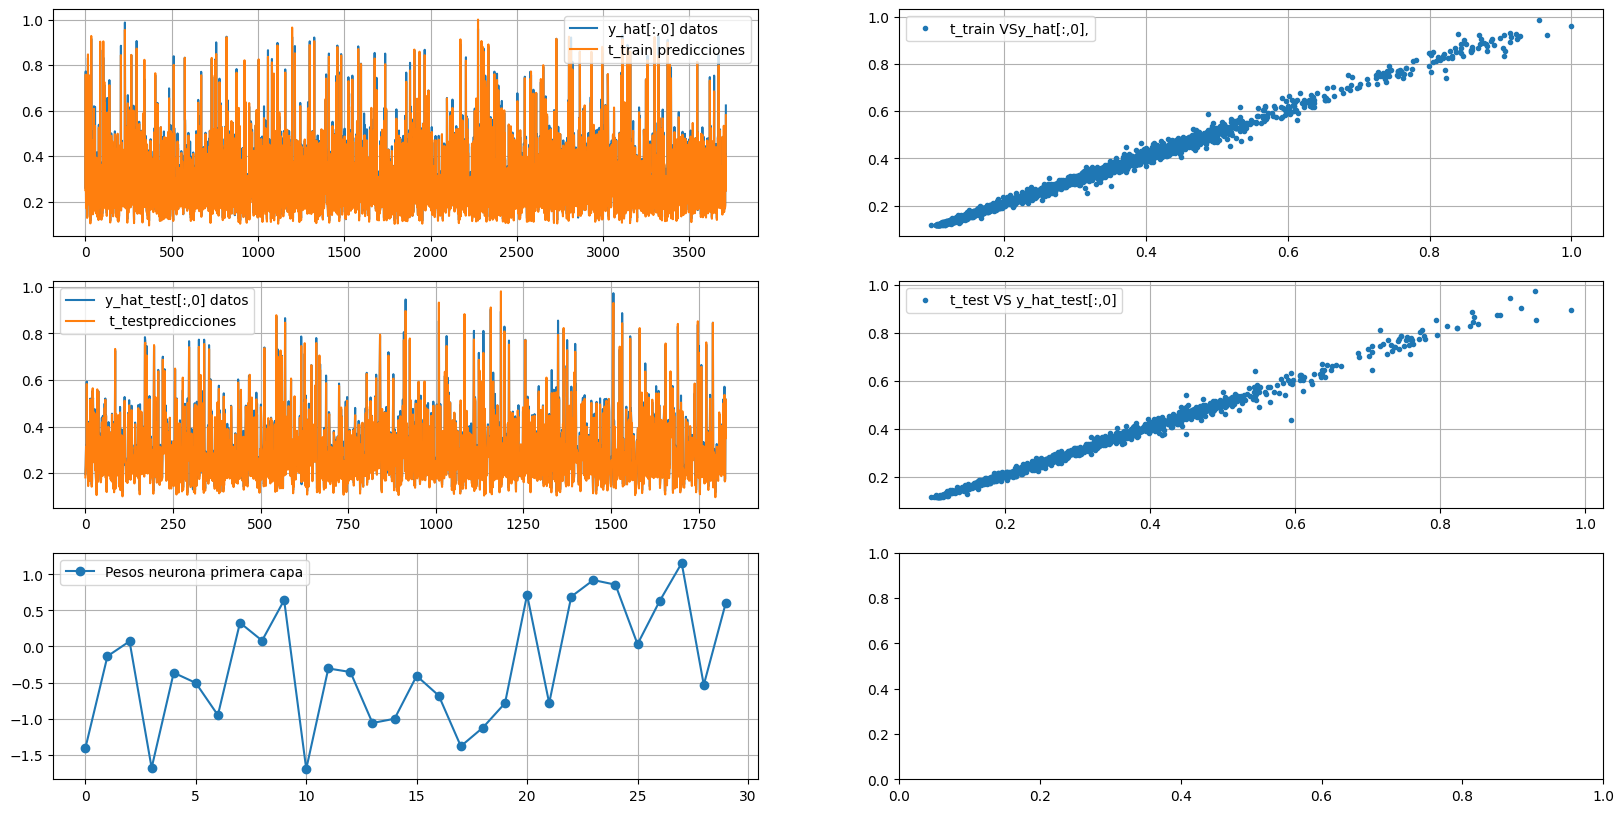

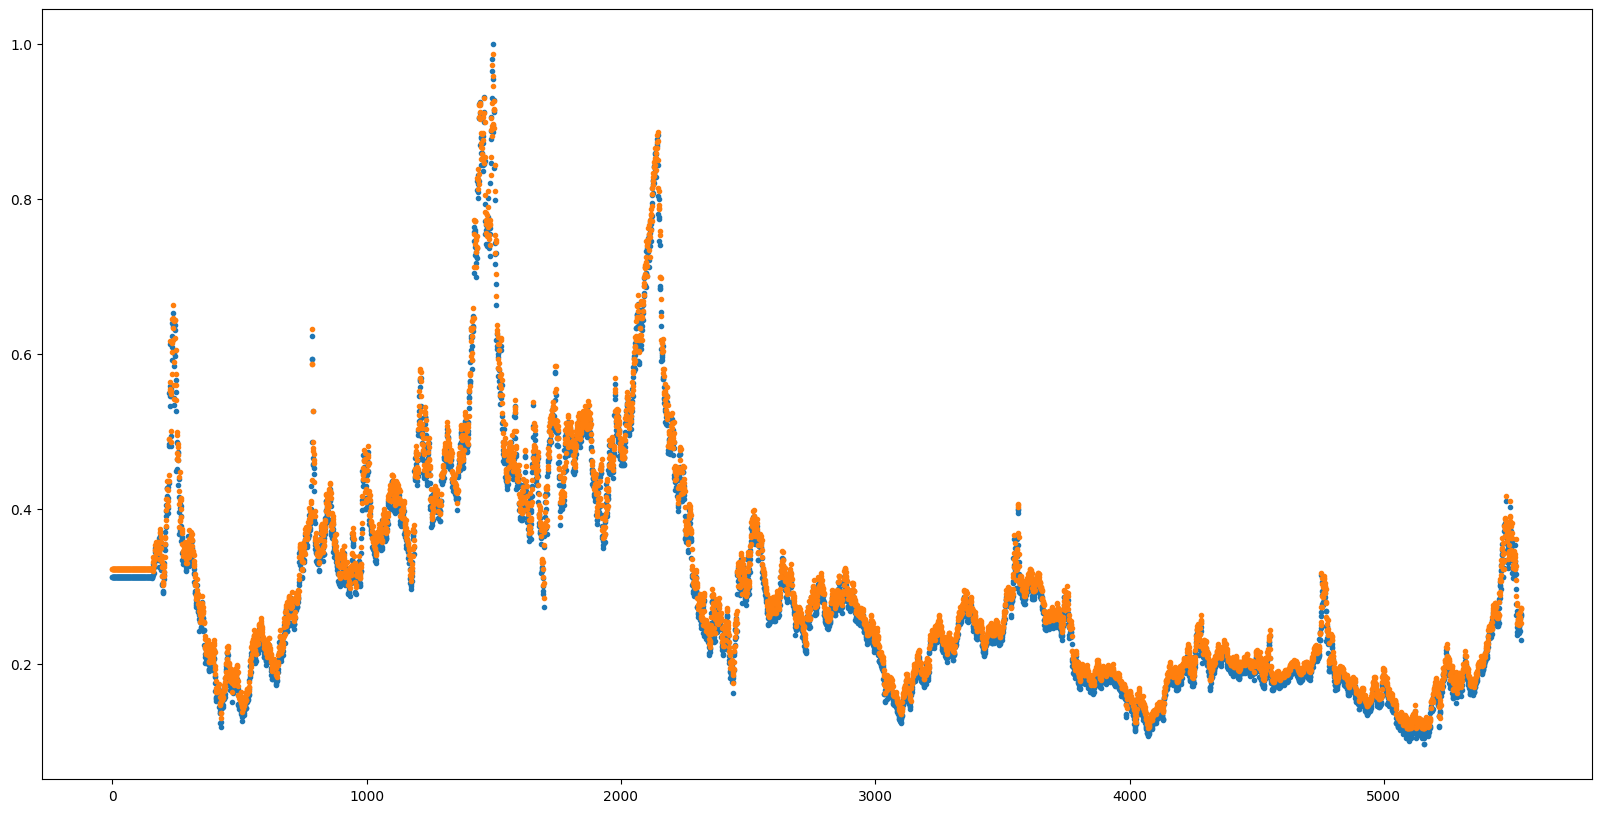

In [36]:
# 3 Entreno la red 2 que use en Prac_CNN_RNN_Ej04_Fernando_Gallego.ipynb con los
# datos de 'NATURALGAS'/"NG=F"
DAT_1 = sacar_close_normalizado_y_con_numero_de_valores_SIN_RETORNO_LOG (y)
x_train, x_test, t_train, t_test, data_x, data_y = Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG = 11,DAT_1 = DAT_1)

#NO SIEMPRE A LA PRIMERA APRENDE. HAY QUE DARLE VARIAS VECES
model, hist = activo_caso_2(x_train, x_test, t_train, t_test)
#model_title = 'EJ_4_CASO_1_Conv1D(10, 3_Conv1D(1, 3_GRU(10_NORM_Y_SIN_RETORNO_LOG.'
#salida, df = datos_para_comparar_modelos (x_train, t_train, x_test, t_test, model)

# 4. Visualizo los resultados que da entre lo predicho y lo que que era realmente
data_y_hat = model(data_x)
plt.figure(figsize=(20,10))
plt.plot(range(0,len(data_y)),data_y,'.')
plt.plot(range(0,len(data_y)),data_y_hat,'.')
print(data_x.shape, data_y.shape,data_y_hat.shape)

# Una vez hecho esto, utilizando una red auxiliar, calcula la incertidumbre de predicción 
# de la primera red (usando como etiquetas a predecir el valor absoluto del error de 
# predicción de la primera red). 

# referencia # de Incertidumbre_a_la_salida_clase.ipynb

# 5 calculo el valor absoluto del error de predicción de la primera red
t_train_hat = model(x_train)
t_test_hat = model(x_test)
print(np.mean((t_train_hat-t_train)**2), np.mean((t_test_hat-t_test)**2))

Epoch 1/100
105/105 [==============================] - 2s 8ms/step - loss: 4.6809e-04 - val_loss: 8.9520e-05
Epoch 2/100
105/105 [==============================] - 1s 5ms/step - loss: 8.8643e-05 - val_loss: 8.5703e-05
Epoch 3/100
105/105 [==============================] - 1s 6ms/step - loss: 8.6937e-05 - val_loss: 9.0826e-05
Epoch 4/100
105/105 [==============================] - 1s 9ms/step - loss: 8.3220e-05 - val_loss: 9.2160e-05
Epoch 5/100
105/105 [==============================] - 1s 8ms/step - loss: 8.7497e-05 - val_loss: 8.8486e-05
Epoch 6/100
105/105 [==============================] - 1s 9ms/step - loss: 8.7485e-05 - val_loss: 8.5900e-05
Epoch 7/100
105/105 [==============================] - 1s 7ms/step - loss: 8.7009e-05 - val_loss: 8.5210e-05
Epoch 8/100
105/105 [==============================] - 1s 8ms/step - loss: 8.7879e-05 - val_loss: 8.7543e-05
Epoch 9/100
105/105 [==============================] - 1s 5ms/step - loss: 8.8345e-05 - val_loss: 9.9617e-05
Epoch 10/100
105/10

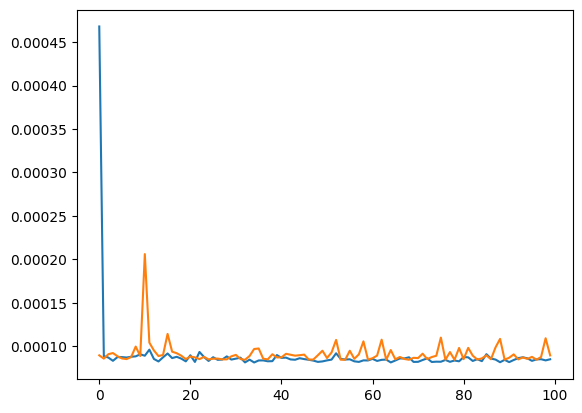

In [37]:
# 6 Estimo el error (incertidumbre de predicción de la primera red 
# (usando como etiquetas a predecir el valor absoluto del error de 
# predicción de la primera red)) que le dio en la red anterior como 
# valor a predecir de la nueva red; 

#Estimación del error (valor absoluto del error de predicción de la primera red)
t_train_hat = model(x_train)
t_test_hat = model(x_test)
error_train = np.abs(t_train_hat[:,0]-t_train)
error_test = np.abs(t_test_hat[:,0]-t_test) 


# 7 Hago una red y la entreno ; que entiendo que no tiene que ser igual a la que
# use para predecir el t_train_hat y el t_test_hat. Uso una sencillita. 
# Build model.
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(10,input_shape=(10,1), activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])


# Do inference.
model2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')
hh2 = model2.fit(x_train, error_train, epochs=100, verbose=True, validation_split = 0.1); # ANTES 300 EPOCAS

plt.plot(hh2.history['loss'])#[-200:])
plt.plot(hh2.history['val_loss'])#[-200:])

(1829, 10, 1) (1829,) (3712, 1) (1829, 10, 1)


<ErrorbarContainer object of 3 artists>

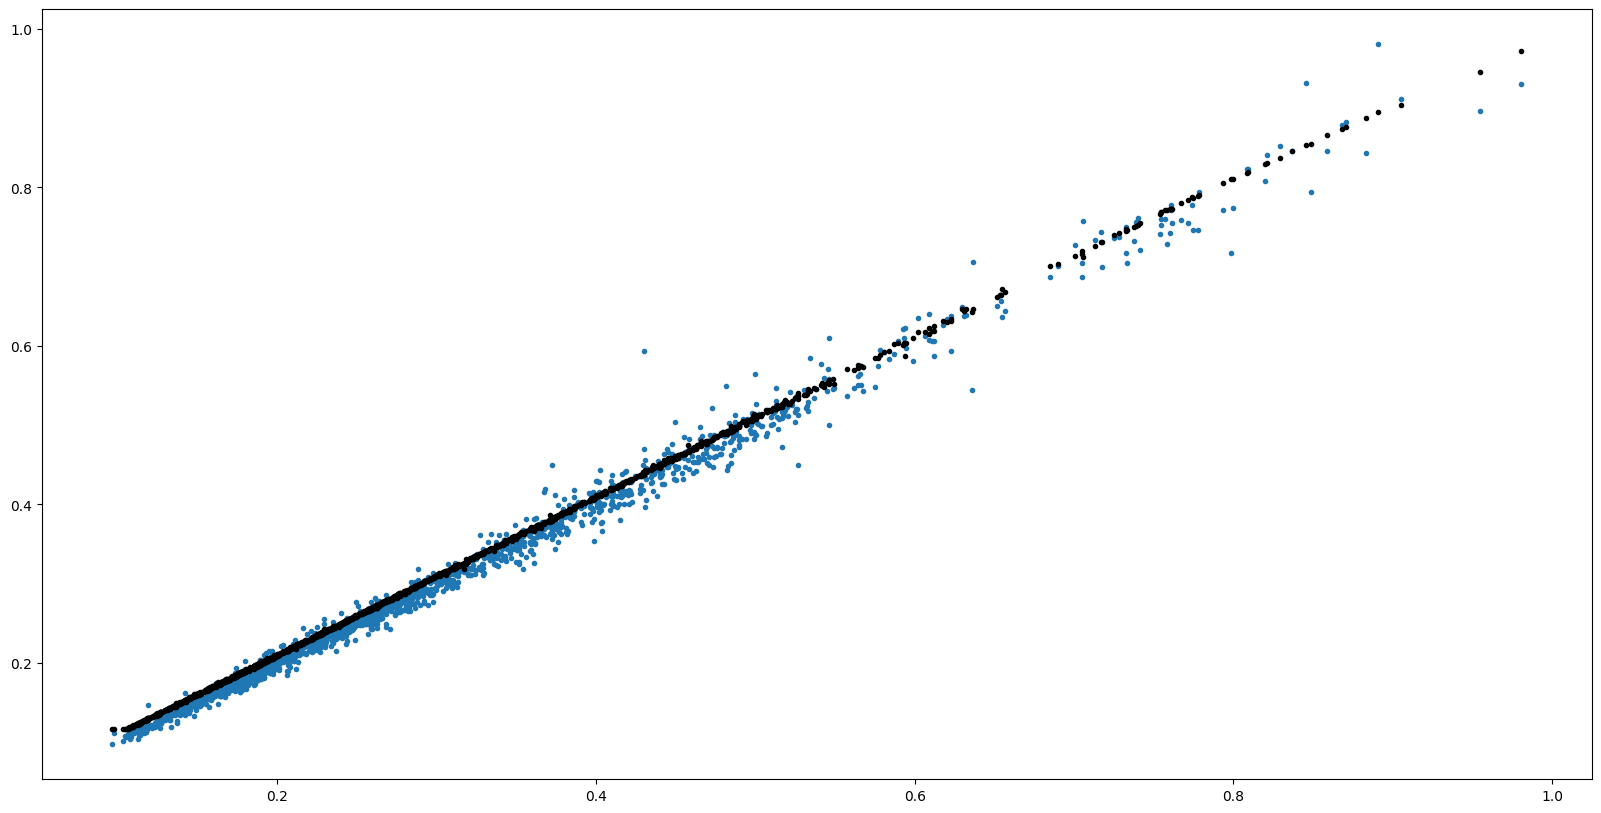

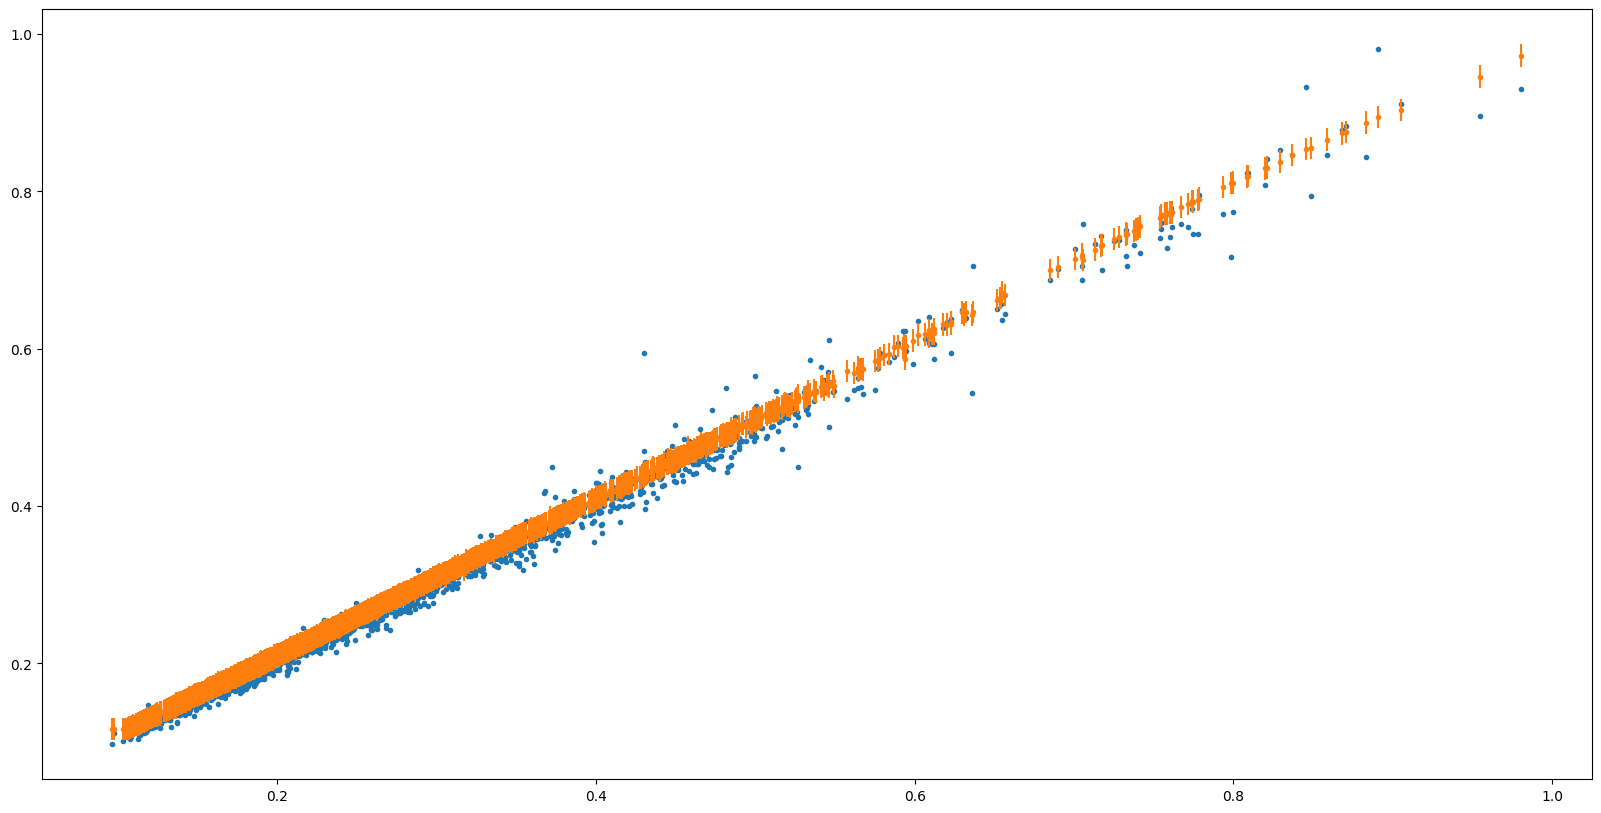

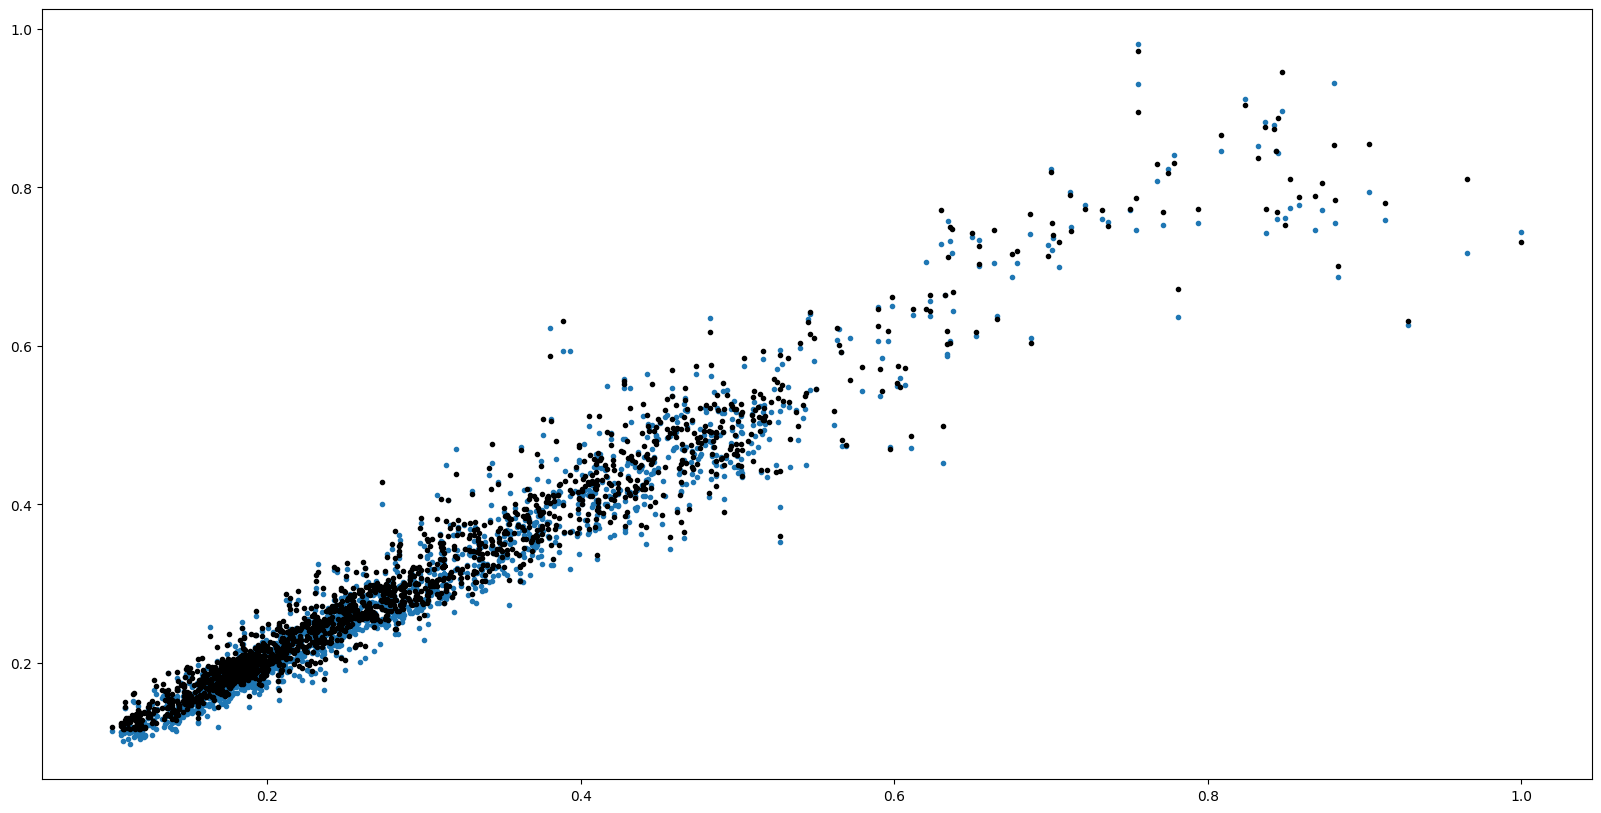

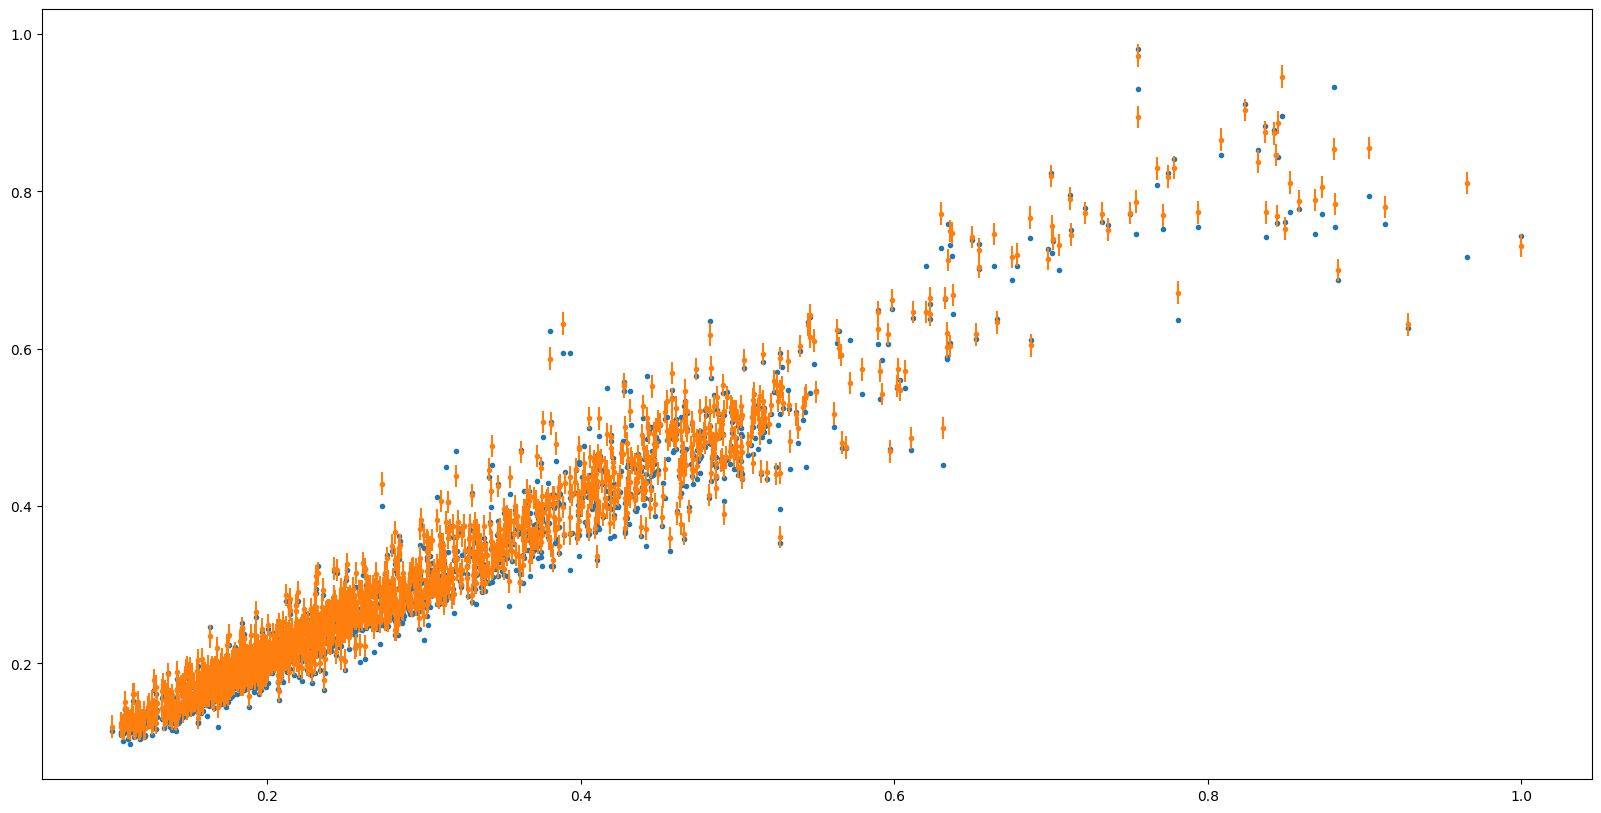

In [39]:
# 8 Grafico los resultados como en Incertidumbre_a_la_salida.ipynb
# Y parecen que no van mal
x_train, x_test, t_train, t_test, data_x, data_y
x_tr = x_train
x_ts = x_test
y_tr = t_train
y_ts = t_test
y_ts_hat = model(x_ts)
y_tr_hat = model(x_tr)
error_tr_hat = model2(x_tr)
error_ts_hat = model2(x_ts)
error_tr = np.abs(y_tr_hat[:,0]-y_tr)
error_ts = np.abs(y_ts_hat[:,0]-y_ts)

print(x_ts.shape,y_ts.shape,y_tr_hat.shape,error_ts_hat.shape)
# respecto al valor mas cercano al dia actual
plt.figure(figsize=(20,10))
plt.plot(x_ts[:,-1,0],y_ts,'.')
plt.plot(x_ts[:,-1,0],y_ts_hat[:,0],'k.')

plt.figure(figsize=(20,10))
plt.plot(x_ts[:,-1,0],y_ts,'.')
plt.errorbar(x_ts[:,-1,0],y_ts_hat[:,0],yerr=error_ts_hat[:,-1,0], fmt=".")


# respecto al dia mas lejano 
plt.figure(figsize=(20,10))
plt.plot(x_ts[:,0,0],y_ts,'.')
plt.plot(x_ts[:,0,0],y_ts_hat[:,0],'k.')

plt.figure(figsize=(20,10))
plt.plot(x_ts[:,0,0],y_ts,'.')
plt.errorbar(x_ts[:,0,0],y_ts_hat[:,0],yerr=error_ts_hat[:,0,0], fmt=".")

# plt.figure(figsize=(20,10))
#plt.plot(error_ts,error_ts_hat,'.')
#lt.plot(error_tr,error_tr_hat,'k.')

#plt.figure(figsize=(20,10))
#plt.plot(x_ts[:,-1,0],error_ts_hat,'.')
#plt.plot(x_ts[:,-1,0],error_ts,'k.')


In [ ]:
# 9. 
# Haz lo mismo pero utilizando solo una red mediante el uso de Tensor Flow Probability.
# usando la misma red que use para estimar t_train_hat y t_test_hat
# intento aplicar el TF sindo la salida dos densas y con tfpl.DistributionLambda

# Referencia Còpia de TFP_Incertidumbre_en_las_Salidas_NN.ipynb de clase

# ver la version que tengo de python en Colab pq TFP solo va con version 3.9
!python --version
!sudo update-alternatives --config python3
# las alternativas que me dan es version 3.8 o 3.10. cAMBIO a 3.8
# Selecciono 2 : 2            /usr/bin/python3.8    1         manual mode
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1

!sudo apt install python3-pip
!python3 --version



    # https://gitlab.tudelft.nl/drama/drama/-/issues/3
 # The error is because we use collections.Sequence instead of collections.abc.
 # Sequence which is deprecated in Python 3.10. From Python 3.9 release notes:
 # Python 3.9 is the last version providing those Python 2 backward 
 # compatibility layers, to give more time to Python projects maintainers 
 # to organize the removal of the Python 2 support and add support for Python 3.9.
  # Aliases to Abstract Base Classes in the collections module, 
  # like collections.Mapping alias to collections.abc.Mapping, are kept for 
  # one last release for backward compatibility. They will be removed 
  # from Python 3.10.

# SE ELIGE LA OPCION DE PYTHON 3.8

(5552,)
(5552, 1)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 10, 10)            390       
                                                                 
 conv1d_36 (Conv1D)          (None, 10, 5)             155       
                                                                 
 conv1d_37 (Conv1D)          (None, 10, 1)             16        
                                                                 
 flatten_2 (Flatten)         (None, 10)                0         
                                                                 
 dense_29 (Dense)            (None, 2)                 22        
                                                                 
 distribution_lambda_8 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                   

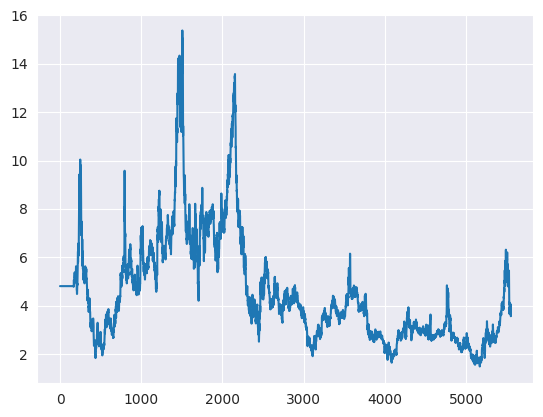

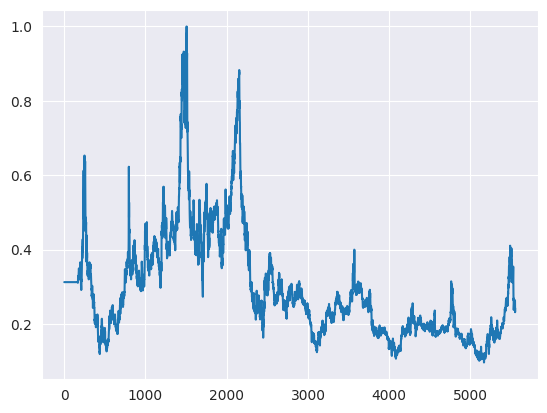

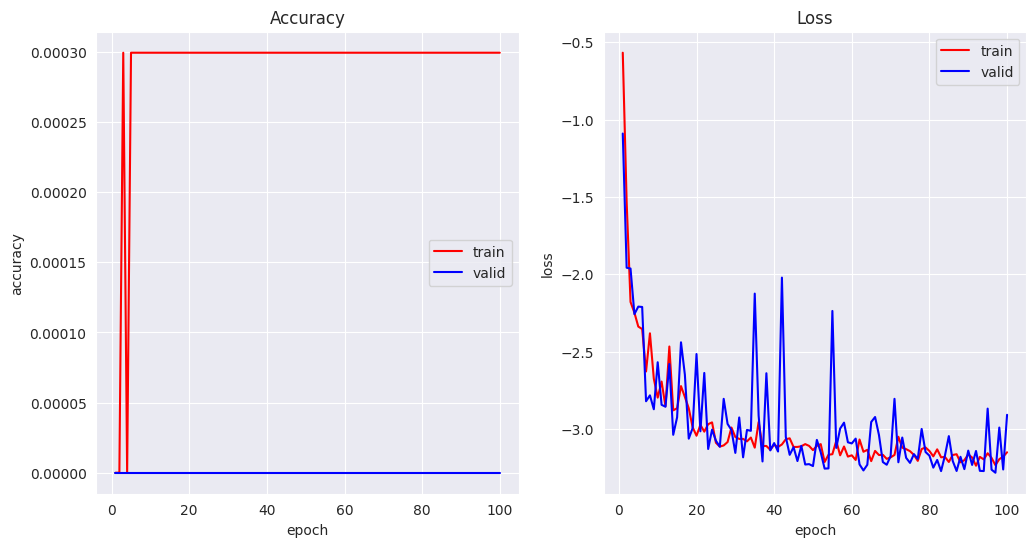

Evaluamos el modelo en train_score: [-2.9013071060180664, 0.00026939655072055757]
116/116 [==============================] - 1s 4ms/step
Predecimos con los datos de train: 0.01506636067492356
Predecimos con los datos de train_cantidad/dimensiones de datos:(3712, 1)
 La media de error en la prediccion en entrenamiento es: 0.2942794820718746
58/58 [==============================] - 1s 4ms/step
 El  error de la predicion usando datos de test es de : 0.01517068988621111
 La media de error en la prediccion en test es: 0.2934496061366643
Mostramos las predicciones de entrenamiento en primera fila y de test en segunda fila:


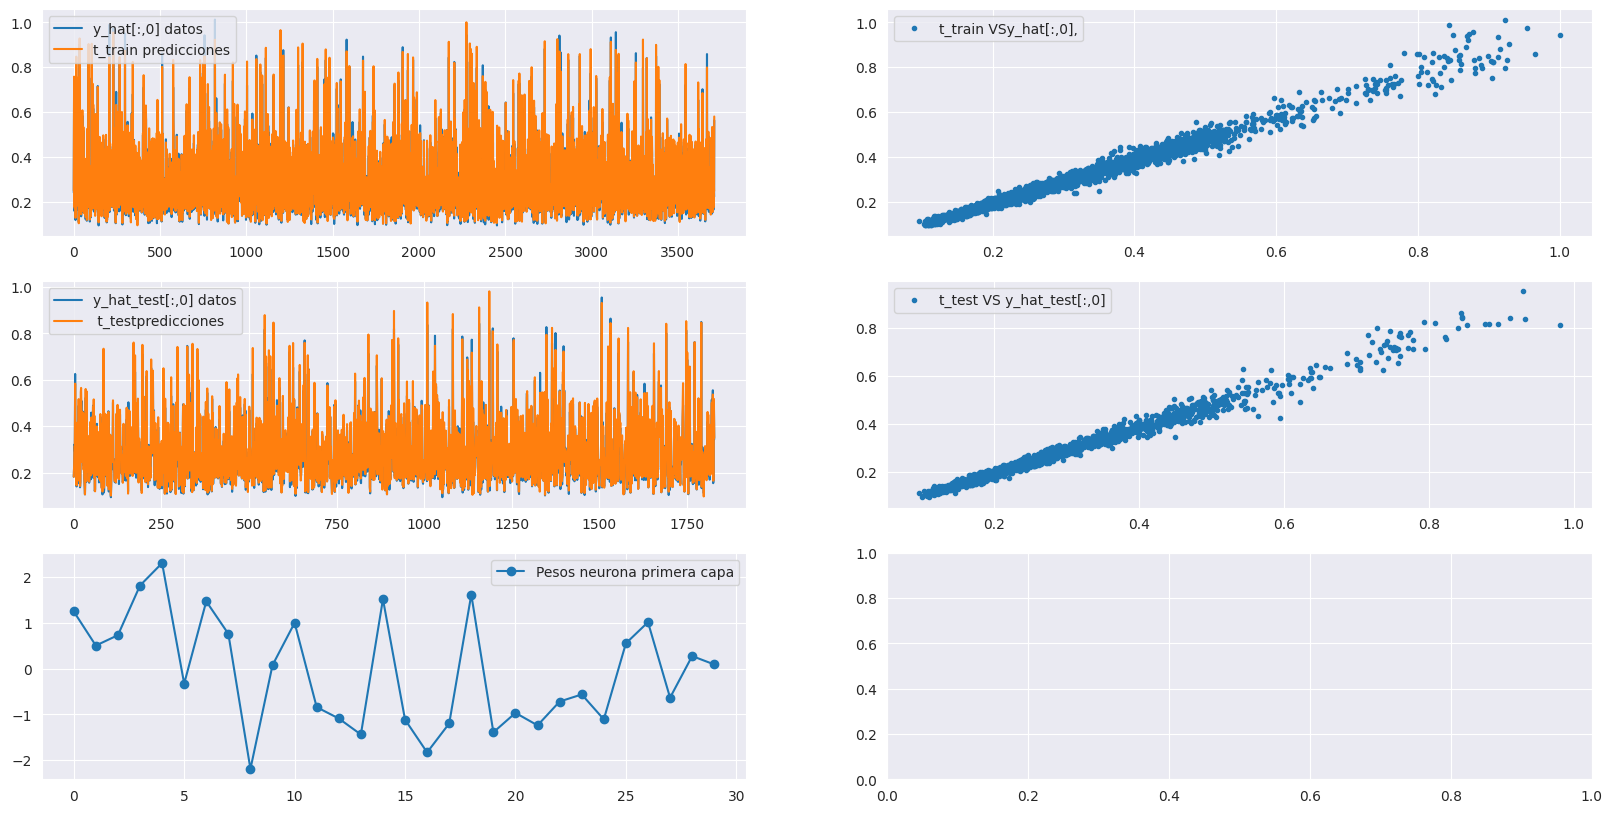

In [68]:
# 10 Usando como refernecia TFP_Incertidumbre_en_las_Salidas_NN.ipynb y las redes anteriores
def activo_caso_2_TFP(x_train, x_test, t_train, t_test):
    
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout,MaxPooling2D 
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, GlobalAveragePooling1D,GlobalMaxPooling1D
    from tensorflow.keras import regularizers
    import tensorflow as tf
    from tensorflow import keras
    import numpy as np
    import matplotlib.pyplot as plt
    from time import time
    import shutil

    !pip install -q -U keras-tuner
    import keras_tuner as kt
    
    
    # nuevo
    # Definimos la función de coste (negative log likelihood)
    import tensorflow as tf
    import tensorflow_probability as tfp
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set_style("darkgrid")
    import pandas as pd
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
    from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
    from tensorflow.keras.optimizers import RMSprop
    import tensorflow_datasets as tfds
    import collections.abc as collections
    tfd = tfp.distributions
    tfpl = tfp.layers    
    def nll(y_true, y_pred):
        return -y_pred.log_prob(y_true)
        
   # model = Sequential([
   #     Dense(2, input_shape=(2)),
   #     tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:])))
   # ])
    model = Sequential()
    model.add(GRU(10, input_shape=(10,1),return_sequences=True))
    model.add(Conv1D(5, 3, activation='relu',padding='same'))
    model.add(Conv1D(1, 3, activation='relu',padding='same'))
    # model.add(GlobalAveragePooling1D())
    model.add(Flatten()) # nuevo
    model.add(Dense(2))
    model.add(tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:]))))
    

    
    

    # Compilamos el modelo
    # model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mean_squared_error', metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = 'mae', metrics=['accuracy'])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = nll, metrics=['accuracy']) # nuevo
    # model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss = nll) # NUEVO
    model.summary()

    # Entrenamos el modelo, nos guardamos la evolución en 'history' 
    # Esto es equivalente a usar callbacks para history
    hist = model.fit(x_train, t_train, batch_size=32, epochs=100, verbose=False, validation_split = 0.1) # antes epochs=1000,verbose=1
    
    #Parametros para evaluar
    score_train, score_test = graficas_y_valores_estandar_evaluacion_modelo(x_train, t_train,x_test, t_test, model, hist)
    ESTUDIO_GRAFICO_DE_RESULTADOS_PARA_EVALUAR(x_train, x_test, t_train, t_test, model)
    
    return model, hist

DAT_1 = sacar_close_normalizado_y_con_numero_de_valores_SIN_RETORNO_LOG (y)
x_train, x_test, t_train, t_test, data_x, data_y = Reordeno_dataset_en_bloques_LAG_dias_y_siguiente_dia_predice_y_split(LAG = 11,DAT_1 = DAT_1)
model_TFP, hist = activo_caso_2_TFP(x_train, x_test, t_train, t_test)


In [69]:
t_model = model_TFP(x_train)
t_sample = t_model.sample()
t_hat = t_model.mean()
t_sd = t_model.stddev()
t_hat,t_sd

# aveces no me aprende. Pero en este caso me ha aprendido y eso se ve por al curca del loss y 
# pq los t_hat,t_sd no son siempre los mismos

(<tf.Tensor: shape=(3712, 1), dtype=float32, numpy=
 array([[0.24421784],
        [0.44267154],
        [0.7328538 ],
        ...,
        [0.25023967],
        [0.23103467],
        [0.58876747]], dtype=float32)>,
 <tf.Tensor: shape=(3712, 1), dtype=float32, numpy=
 array([[0.00976163],
        [0.01718794],
        [0.03760703],
        ...,
        [0.0102322 ],
        [0.0093083 ],
        [0.02625286]], dtype=float32)>)

True μ:  0
Estimated μ:  0.2909942
True σ:  0.375
Estimated σ:  0.14062575
(3712, 10, 1) (3712,) (3712, 1) (3712, 1) (3712, 1) (3712, 1)
(3712,) (3712,) (3712,) (3712,) (3712,) (3712,)


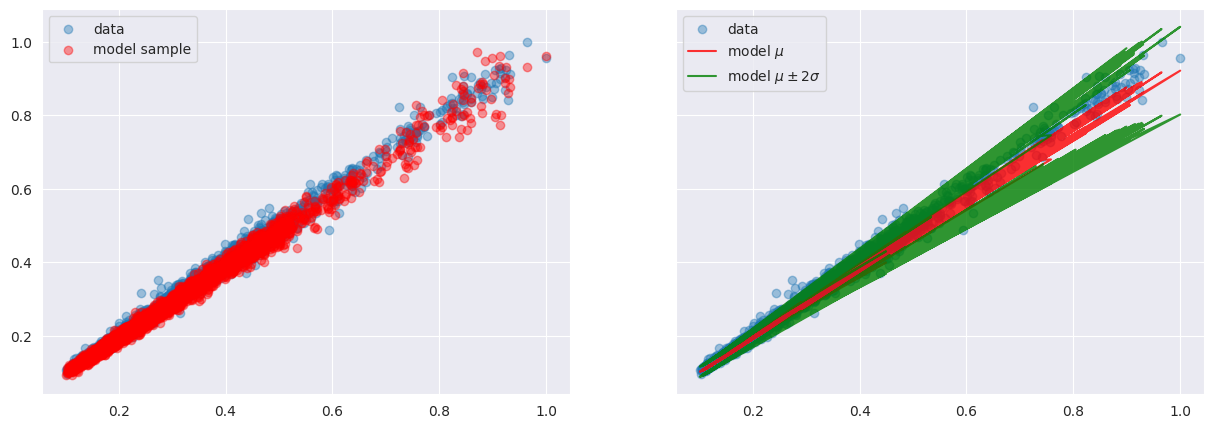

In [111]:
# 11. Visualizo los resultados que da entre lo predicho y lo que que era realmente
# como referencia TFP_Incertidumbre_en_las_Salidas_NN.ipynb ultima parte


t_model = model_TFP(x_train)
t_sample = t_model.sample()


# El modelo tiene media y desviación típica

t_hat = t_model.mean().numpy()
t_sd = t_model.stddev().numpy()
t_hat_m2sd = t_hat -2 * t_sd
t_hat_p2sd = t_hat + 2 * t_sd

print("True μ: ", 0)
print("Estimated μ: ", t_hat.mean())
print("True σ: ", 3/8)
print("Estimated σ: ", t_sd.mean())

print(x_train.shape, t_train.shape,t_sample.shape,t_hat.shape,t_hat_m2sd.shape,t_hat_p2sd.shape)

x_train_graf = x_train[:,-1,0]# del ultimo dia antes del perdecido
t_train_graf  = t_train
t_sample_graf  = t_sample[:,0]
t_hat_graf  = t_hat[:,0]
t_hat_m2sd_graf  = t_hat_m2sd[:,0]
t_hat_p2sd_graf = t_hat_p2sd[:,0]

print(x_train_graf.shape, t_train_graf.shape,t_sample_graf.shape,t_hat_graf.shape,t_hat_m2sd_graf.shape,t_hat_p2sd_graf.shape)



fig, (ax1, ax2) =plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train_graf , t_train_graf , alpha=0.4, label='data')
ax1.scatter(x_train_graf , t_sample_graf , alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train_graf , t_train_graf , alpha=0.4, label='data')
ax2.plot(x_train_graf , t_hat_graf , color='red', alpha=0.8, label='model $\mu$')

ax2.plot(x_train_graf , t_hat_m2sd_graf , color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train_graf , t_hat_p2sd_graf , color='green', alpha=0.8)
ax2.legend()
plt.show()






In [112]:
# 12 Vuelvo a poner ultima version de python
# ver la version que tengo de python en Colab pq TFP solo va con version 3.9
!python --version
!sudo update-alternatives --config python3
# las alternativas que me dan es version 3.8 o 3.10. Intneto cambiar a 3.8
# Selecciono 2 : 2            /usr/bin/python3.8    1         manual mode
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1

!sudo apt install python3-pip
!python3 --version

Python 3.8.10
There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
  0            /usr/bin/python3.10   2         auto mode
  1            /usr/bin/python3.10   2         manual mode
* 2            /usr/bin/python3.8    1         manual mode

Press <enter> to keep the current choice[*], or type selection number: 0
update-alternatives: using /usr/bin/python3.10 to provide /usr/bin/python3 (python3) in auto mode
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-pip is already the newest version (20.0.2-5ubuntu1.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Python 3.10.11
